In [1]:
import pandas as pd
import numpy as np
import os, ast
import matplotlib.pyplot as plt

## Load The Data

In [2]:
dataset_name = "switching_interference"
data_path = 'data'
df = pd.read_csv(f'{data_path}/{dataset_name}.csv')

## Basic Preprocessing for Modeling: Getting Response and Response Times

In [3]:
# Parse key presses as list of dictionaries
df['key_presses'] = df['key_presses'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Drop training blocks
df = df[~df['block'].str.startswith('train_')]
# Add integer participant ids
df['participant_id'] = pd.factorize(df['subj_id'])[0]
# Add number of responses
df['n_responses'] = df['key_presses'].apply(len)
# Add rt and response columns
df['rt'] = df.apply(lambda row: (row['key_presses'][0]['time'] - row['go_1_start']) / 1000 if len(row['key_presses']) > 0 else 0, axis=1)
df['response'] = df.apply(lambda row: 1.0 if len(row['key_presses']) > 0 and row['key_presses'][0]['correct'] else -1.0, axis=1)

### Calculate task switches

In [4]:
# Shift task_1 column by 1 to get the previous trial's task and compare
df['task_switch'] = (df['task_1'] != df['task_1'].shift(1)).astype(int)
# Ensure the first trial is always 0
df.loc[0, 'task_switch'] = 0

### Filter participants and trials

In [5]:
ACCURACY_THRESHOLD = 0.7
MAX_NUMBER_OF_RESPONSES = 3

In [6]:
REMOVE_PARTICIPANTS_WITH_LOW_ACCURACY = True #@param {type: "boolean"}
REMOVE_PARTICIPANTS_WITH_TOO_MANY_RESPONSES = True #@param {type:"boolean"}
REMOVE_PARTICIPANTS_WITH_ZERO_RT = True #@param {type:"boolean"}
REMOVE_TRIALS_WITH_MORE_THAN_MAX_RESPONSES = True #@param {type: "boolean"}
REMOVE_TRIALS_WITH_NO_RESPONSE = True #@param {type: "boolean"}

In [7]:
df.describe()

,Unnamed: 0,trial_index,cue_1_start,cue_1_dur,cue_1_end,task_2,cue_2_start,cue_2_dur,cue_2_end,go_1_start,...,or_2_start,or_2_dur,or_2_end,trial_start,trial_end,participant_id,n_responses,rt,response,task_switch
count,53840.000000,53840.000000,53840.000000,53840.000000,53840.000000,0.0,0.0,0.0,0.0,53840.000000,...,0.0,0.0,0.0,53840.000000,53840.000000,53840.000000,53840.000000,53840.000000,53840.000000,53841.000000
mean,39.500000,39.500000,116921.414266,2527.132244,119448.546509,NaN,NaN,NaN,NaN,116921.414266,...,NaN,NaN,NaN,116921.414266,119448.546509,85.631501,1.328678,0.943871,0.534993,0.505377
std,23.092421,23.092421,71244.064053,397.850360,71319.863801,NaN,NaN,NaN,NaN,71244.064053,...,NaN,NaN,NaN,71244.064053,71319.863801,49.731277,1.700989,0.438016,0.844865,0.499976
min,0.000000,0.000000,0.000000,1845.000000,1955.200000,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,0.000000,1955.200000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,19.750000,19.750000,55876.030000,2300.000000,58013.575000,NaN,NaN,NaN,NaN,55876.030000,...,NaN,NaN,NaN,55876.030000,58013.575000,43.000000,1.000000,0.702100,1.000000,0.000000
50%,39.500000,39.500000,113692.450000,2600.000000,116009.650000,NaN,NaN,NaN,NaN,113692.450000,...,NaN,NaN,NaN,113692.450000,116009.650000,86.000000,1.000000,0.893700,1.000000,1.000000
75%,59.250000,59.250000,173871.475750,2900.000000,176603.240000,NaN,NaN,NaN,NaN,173871.475750,...,NaN,NaN,NaN,173871.475750,176603.240000,129.000000,1.000000,1.157310,1.000000,1.000000
max,79.000000,79.000000,300725.400000,3000.000000,303525.400000,NaN,NaN,NaN,NaN,300725.400000,...,NaN,NaN,NaN,300725.400000,303525.400000,171.000000,85.000000,2.972800,1.000000,1.000000


In [10]:
def filter(df):
    print(len(df), "number of trials and", len(df['subj_id'].unique()) ,"participants before filtering.")
    if REMOVE_PARTICIPANTS_WITH_ZERO_RT:
        # Identify participants with any rt value of 0
        participants_with_rt_zero = df.groupby('subj_id')['rt'].apply(lambda x: (x == 0.0).any())
        # Get participants to keep (those without any rt value of 0)
        participants_to_keep = participants_with_rt_zero[~participants_with_rt_zero].index
        # Filter the DataFrame to keep only the participants without any rt value of 0
        df = df[df['subj_id'].isin(participants_to_keep)]
        print(len(df), "number of trials and", len(df['subj_id'].unique()) ,"participants after dropping participants with 0 RT.")
    if REMOVE_PARTICIPANTS_WITH_TOO_MANY_RESPONSES:
        # Get indexes of participants who have max number of responses and not more
        participants_to_drop = df.groupby('subj_id')['n_responses'].apply(lambda x: (x > MAX_NUMBER_OF_RESPONSES).any())
        # Filter the DataFrame to keep only the participants without any rt value of 0
        participants_to_keep = participants_to_drop[~participants_to_drop].index
        df = df[df['subj_id'].isin(participants_to_keep)]
        print(len(df), "number of trials and", len(df['subj_id'].unique()) ,"participants after dropping participants with too many responses")   
    if REMOVE_PARTICIPANTS_WITH_LOW_ACCURACY:
        accuracy = df.groupby('subj_id')['response'].apply(lambda x: (x == 1.0).mean())
        participants_to_keep = accuracy[accuracy >= ACCURACY_THRESHOLD].index
        df = df[df['subj_id'].isin(participants_to_keep)]        
        print(len(df), "number of trials and", len(df['subj_id'].unique()) ,"participants after filtering out low accuracy participants")
    if REMOVE_TRIALS_WITH_MORE_THAN_MAX_RESPONSES:
      df = df[df['key_presses'].apply(len) <= MAX_NUMBER_OF_RESPONSES]
      print(len(df), "number of trials and", len(df['subj_id'].unique()) ,"participants after filtering out high response trials.")
    if REMOVE_TRIALS_WITH_NO_RESPONSE:
      df = df[df['key_presses'].apply(len) > 0]
      print(len(df), "number of trials and", len(df['subj_id'].unique()) ,"participants after filtering no response trials.") 
    
    return df

In [11]:
df = filter(df)

53841 number of trials and 173 participants before filtering.
18160 number of trials and 57 participants after dropping participants with 0 RT.
14000 number of trials and 44 participants after dropping participants with too many responses
13680 number of trials and 43 participants after filtering out low accuracy participants
13680 number of trials and 43 participants after filtering out high response trials.
13680 number of trials and 43 participants after filtering no response trials.


In [12]:
df.describe()

,Unnamed: 0,trial_index,cue_1_start,cue_1_dur,cue_1_end,task_2,cue_2_start,cue_2_dur,cue_2_end,go_1_start,...,or_2_start,or_2_dur,or_2_end,trial_start,trial_end,participant_id,n_responses,rt,response,task_switch
count,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,0.0,0.0,0.0,0.0,13680.000000,...,0.0,0.0,0.0,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000
mean,39.500000,39.500000,121748.224235,2655.906433,124404.130667,NaN,NaN,NaN,NaN,121748.224235,...,NaN,NaN,NaN,121748.224235,124404.130667,95.116959,1.052632,0.885209,0.892982,0.502266
std,23.093051,23.093051,72779.429313,339.789905,72822.189042,NaN,NaN,NaN,NaN,72779.429313,...,NaN,NaN,NaN,72779.429313,72822.189042,44.752124,0.240638,0.287035,0.450108,0.500013
min,0.000000,0.000000,0.400000,1845.000000,1955.300000,NaN,NaN,NaN,NaN,0.400000,...,NaN,NaN,NaN,0.400000,1955.300000,4.000000,1.000000,0.089100,-1.000000,0.000000
25%,19.750000,19.750000,59999.575000,2300.000000,61844.575000,NaN,NaN,NaN,NaN,59999.575000,...,NaN,NaN,NaN,59999.575000,61844.575000,56.000000,1.000000,0.690815,1.000000,0.000000
50%,39.500000,39.500000,119886.850000,2800.000000,121815.400000,NaN,NaN,NaN,NaN,119886.850000,...,NaN,NaN,NaN,119886.850000,121815.400000,98.000000,1.000000,0.822000,1.000000,1.000000
75%,59.250000,59.250000,182702.625000,2970.000000,185304.085000,NaN,NaN,NaN,NaN,182702.625000,...,NaN,NaN,NaN,182702.625000,185304.085000,138.000000,1.000000,1.006070,1.000000,1.000000
max,79.000000,79.000000,300725.400000,3000.000000,303525.400000,NaN,NaN,NaN,NaN,300725.400000,...,NaN,NaN,NaN,300725.400000,303525.400000,169.000000,3.000000,2.851300,1.000000,1.000000


In [121]:
df.to_csv(f'data/{dataset_name}_preprocessed.csv', index=False)

## Descriptive Stuff after Filtering

In [13]:
df.head()

,Unnamed: 0,subj_id,prolific_pid,block,trial_index,file_path,task_1,cue_1_start,cue_1_dur,cue_1_end,...,or_2_dur,or_2_end,trial_start,trial_end,key_presses,participant_id,n_responses,rt,response,task_switch
1865,0.0,5aLYmsSb0wjFCzSc,628667709c7e31f9018e77d5,block_1,0.0,./aw_task_switching/res/20.json,or,187.891,2970.0,3157.891,...,NaN,NaN,187.891,3157.891,"[{'correct': True, 'key': 'd', 'time': 1074.79...",4.0,1.0,0.886909,1.0,1.0
1866,1.0,5aLYmsSb0wjFCzSc,628667709c7e31f9018e77d5,block_1,1.0,./aw_task_switching/res/20.json,mov,3530.268,2970.0,6500.268,...,NaN,NaN,3530.268,6500.268,"[{'correct': True, 'key': 'f', 'time': 4702.29...",4.0,1.0,1.172032,1.0,1.0
1867,2.0,5aLYmsSb0wjFCzSc,628667709c7e31f9018e77d5,block_1,2.0,./aw_task_switching/res/20.json,mov,6872.468,2970.0,9842.468,...,NaN,NaN,6872.468,9842.468,"[{'correct': True, 'key': 'f', 'time': 8484.79...",4.0,1.0,1.612332,1.0,0.0
1868,3.0,5aLYmsSb0wjFCzSc,628667709c7e31f9018e77d5,block_1,3.0,./aw_task_switching/res/20.json,mov,10214.668,2970.0,13184.668,...,NaN,NaN,10214.668,13184.668,"[{'correct': True, 'key': 'f', 'time': 11712}]",4.0,1.0,1.497332,1.0,0.0
1869,4.0,5aLYmsSb0wjFCzSc,628667709c7e31f9018e77d5,block_1,4.0,./aw_task_switching/res/20.json,or,13557.045,2970.0,16527.045,...,NaN,NaN,13557.045,16527.045,"[{'correct': True, 'key': 'k', 'time': 14480.5...",4.0,1.0,0.923555,1.0,1.0


Text(0, 0.5, 'Error (%)')

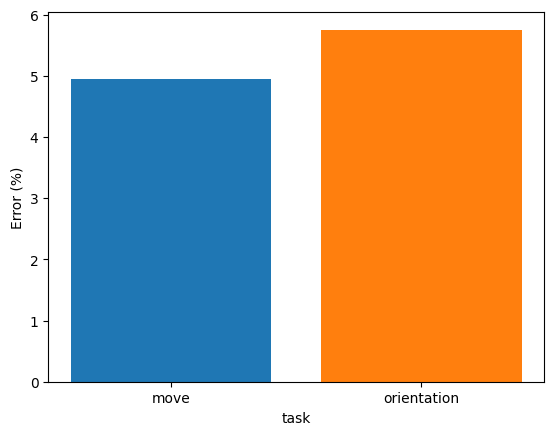

In [14]:
df_move = df[df['task_1'] == 'mov']
df_or = df[df['task_1']=='or']

error_move = len(df_move[df_move['response']==-1.0]['response'])
error_or = len(df_or[df_or['response']==-1.0]['response'])

error_rate_move = (error_move / len(df_move)) * 100
error_rate_or = (error_or / len(df_or)) * 100

fig, ax = plt.subplots()

bar1 = ax.bar('move', error_rate_move)
bar2 = ax.bar('orientation', error_rate_or)

ax.set_xlabel('task')
ax.set_ylabel('Error (%)')


Text(0, 0.5, 'Error (%)')

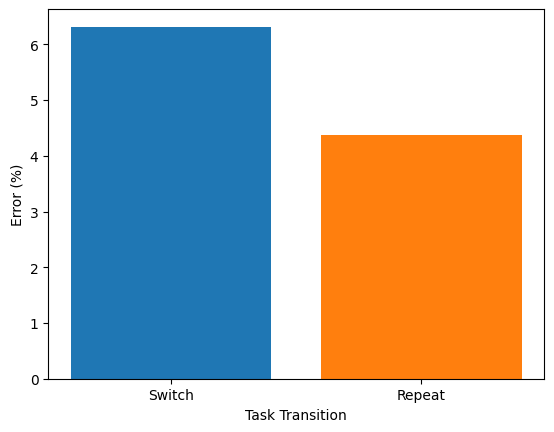

In [15]:
# Accuracy in Task Switching

df_switch = df[df['task_switch']==1]
df_repeat = df[df['task_switch']==0]

error_switch = len(df_switch[df_switch['response']==-1])
error_repeat = len(df_repeat[df_repeat['response']==-1])

error_rate_switch = (error_switch / len(df_switch)) * 100
error_rate_repeat = (error_repeat / len(df_repeat)) * 100

fig, ax = plt.subplots()

bar1 = ax.bar('Switch', error_rate_switch)
bar2 = ax.bar('Repeat', error_rate_repeat)

ax.set_xlabel('Task Transition')
ax.set_ylabel('Error (%)')

Text(0, 0.5, 'Reaction Times')

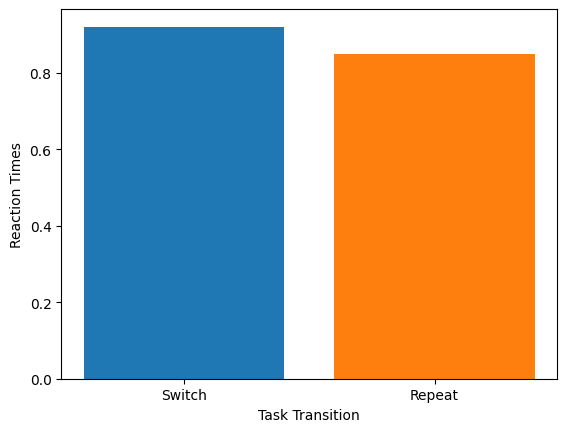

In [16]:
# RTs in Task Switching

rt_switch = df_switch['rt'].mean()
rt_repeat = df_repeat['rt'].mean()



fig, ax = plt.subplots()

bar1 = ax.bar('Switch', rt_switch)
bar2 = ax.bar('Repeat', rt_repeat)

ax.set_xlabel('Task Transition')
ax.set_ylabel('Reaction Times')

Text(0, 0.5, 'Error rates (%)')

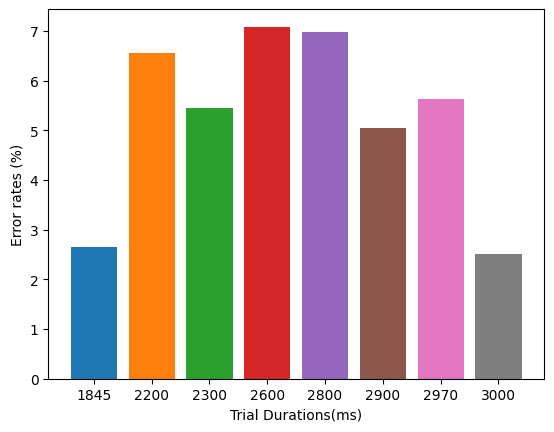

In [17]:
# Looking at trial durations
trialdur_1845 = df[df['cue_1_dur']==1845]
trialdur_2200 = df[df['cue_1_dur']==2200]
trialdur_2300 = df[df['cue_1_dur']==2300]
trialdur_2600 = df[df['cue_1_dur']==2600]
trialdur_2800 = df[df['cue_1_dur']==2800]
trialdur_2900 = df[df['cue_1_dur']==2900]
trialdur_2970 = df[df['cue_1_dur']==2970]
trialdur_3000 = df[df['cue_1_dur']==3000]

error_1845 = len(trialdur_1845[trialdur_1845['response']==-1.0]['response'])
error_rate_1845 = (error_1845 / len(trialdur_1845)) * 100

error_2200 = len(trialdur_2200[trialdur_2200['response']==-1.0]['response'])
error_rate_2200 = (error_2200 / len(trialdur_2200)) * 100

error_2300 = len(trialdur_2300[trialdur_2300['response']==-1.0]['response'])
error_rate_2300 = (error_2300 / len(trialdur_2300)) * 100

error_2600 = len(trialdur_2600[trialdur_2600['response']==-1.0]['response'])
error_rate_2600 = (error_2600 / len(trialdur_2600)) * 100

error_2800 = len(trialdur_2800[trialdur_2800['response']==-1.0]['response'])
error_rate_2800 = (error_2800 / len(trialdur_2800)) * 100

error_2900 = len(trialdur_2900[trialdur_2900['response']==-1.0]['response'])
error_rate_2900 = (error_2900 / len(trialdur_2900)) * 100

error_2970 = len(trialdur_2970[trialdur_2970['response']==-1.0]['response'])
error_rate_2970 = (error_2970 / len(trialdur_2970)) * 100

error_3000 = len(trialdur_3000[trialdur_3000['response']==-1.0]['response'])
error_rate_3000 = (error_3000 / len(trialdur_3000)) * 100

fig, ax = plt.subplots()

bar1 = ax.bar('1845', error_rate_1845)
bar2 = ax.bar('2200', error_rate_2200)
bar3 = ax.bar('2300', error_rate_2300)
bar4 = ax.bar('2600', error_rate_2600)
bar5 = ax.bar('2800', error_rate_2800)
bar6 = ax.bar('2900', error_rate_2900)
bar7 = ax.bar('2970', error_rate_2970)
bar8 = ax.bar('3000', error_rate_3000)

ax.set_xlabel('Trial Durations(ms)')
ax.set_ylabel('Error rates (%)')

## Stats on Maximum Trial Length across Paricipants

In [18]:
trial_length_count = df['cue_1_dur'].value_counts().sort_index()
trial_length_participants = df.groupby('cue_1_dur')['participant_id'].nunique()

df_trials = pd.DataFrame(
    np.column_stack(
        [np.unique(df['cue_1_dur']), trial_length_count, trial_length_count/sum(trial_length_count), trial_length_participants, trial_length_participants/sum(trial_length_participants)]
    ),
    columns=['trialDuration', 'trialCount', 'trialPercentage', 'participantCount', 'participantPercentage']
)

df_trials

,trialDuration,trialCount,trialPercentage,participantCount,participantPercentage
0,1845.0,640.0,0.046784,2.0,0.046512
1,2200.0,320.0,0.023392,1.0,0.023256
2,2300.0,3840.0,0.280702,12.0,0.279070
3,2600.0,1200.0,0.087719,4.0,0.093023
4,2800.0,960.0,0.070175,3.0,0.069767
5,2900.0,2560.0,0.187135,8.0,0.186047
6,2970.0,3200.0,0.233918,10.0,0.232558
7,3000.0,960.0,0.070175,3.0,0.069767


### Plot RTs

In [31]:
df['rt'] = df['response_time_0'] / 1000
df['response'] = df.apply(lambda row: 1.0 if len(row['key_presses']) > 0 and row['key_presses'][0]['correct'] else -1.0, axis=1)

(-4.0, 4.0)

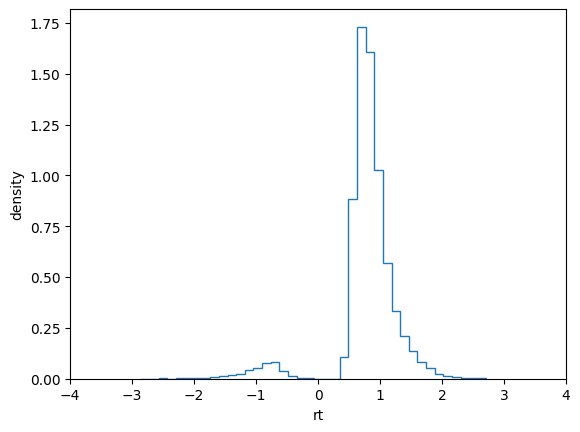

In [113]:
plt.hist(df['rt'] * df['response'],
         histtype='step', bins = 40, density=True)
plt.xlabel('rt')
plt.ylabel('density')
plt.xlim(-4, 4)